## Sentinel-3 L1 SLSTR Wild Fire Mapping via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'sentinelhub-py'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub-py'

In [3]:
# add repo source directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )
sys.path.insert(0, os.path.join( root_path, 'notebooks' ) )

In [4]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-3' )
cfg_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub-py\\cfg\\sentinel-3'

### _Load configuration file from repository cfg sub-directory_ 

In [5]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's3-timeseries-slstr-fires.yml' )

In [6]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    collection: SENTINEL3_SLSTR
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: ["F1"],
                        output: [ { 
                            id: "heatmap",
                            bands: 3,
                        }, {
                            id: "temperature",
                            bands: 1,
                            sampleType: "FLOAT32"
                        } ]
                    }
                }
                // Create a Red gradient visualiser from 274-500 K
                var viz = ColorGradientVisualizer.createRedTemperature(274,500)
                function evaluatePixel(sample) {
                    return { 
                        heatmap: viz.process(sample.F1),
                        temperature: [ sample.F1 ],
                    }
                }
responses:
    heatmap: TIFF
    temperature: TIFF
aoi:
    pathname: <pathname_to_ao

In [7]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define bounding box encompassing border between Democratic Republic of the Congo and Uganda_

In [8]:
# define min and max latlons - see http://bboxfinder.com/
coords = 21.379395,-13.306336,25.982667,-9.148848
resolution = 300

In [9]:
# create instance of shclient class
from client import ShClient
client = ShClient( config )

In [10]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

541091.3351339125,8528956.01900979,1048099.7850051167,8984895.009098645 32734


In [11]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1690, 1520)

### _Historical reports suggest significant wildfire / deforestation activity took place in August 2020_

In [12]:
# imports
from datetime import datetime
from datetime import timedelta

# start of may 2021
dt = datetime( 2020, 8, 23, 0, 0, 0 )
timeframe = { 'start' : dt, 'end' : dt + timedelta(hours=72) } 
timestamps = client.getTimeStamps( bbox, timeframe )

timestamps

[datetime.datetime(2020, 8, 23, 8, 11, 27, 458000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 23, 20, 43, 22, 30000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 24, 7, 45, 16, 504000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 24, 20, 17, 11, 59000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 25, 7, 58, 28, 630000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 25, 20, 30, 23, 137000, tzinfo=tzutc())]

In [13]:
# get timestamps morning passes
day_timestamps = []
for timestamp in timestamps:
    if timestamp.hour >= 6 and timestamp.hour < 18:
        day_timestamps.append( timestamp ) 

day_timestamps

[datetime.datetime(2020, 8, 23, 8, 11, 27, 458000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 24, 7, 45, 16, 504000, tzinfo=tzutc()),
 datetime.datetime(2020, 8, 25, 7, 58, 28, 630000, tzinfo=tzutc())]

### _Download S3 SLSTR time series imagery via Process API client_

In [14]:
# get mosaics between timeframes
response = client.getTimeSeries ( bbox, timeframe, resolution, timestamps=day_timestamps )
response._df

,heatmap.tif,temperature.tif,time
0,"[[[50, 0, 0], [50, 0, 0], [50, 0, 0], [50, 0, ...","[[305.0, 305.0, 305.01, 305.01, 305.01, 305.01...",2020-08-23 08:11:27.458000+00:00
1,"[[[67, 0, 0], [56, 0, 0], [56, 0, 0], [56, 0, ...","[[315.26, 308.69, 308.69, 308.69, 306.58, 306....",2020-08-24 07:45:16.504000+00:00
2,"[[[59, 0, 0], [59, 0, 0], [53, 0, 0], [53, 0, ...","[[310.33, 310.33, 306.62, 306.62, 306.62, 299....",2020-08-25 07:58:28.630000+00:00


### _Examine distribution of 'hot' brightness temperatures across time series_

c:\program files\python36\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\program files\python36\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


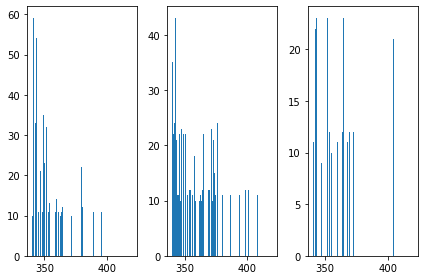

In [15]:
import matplotlib.pyplot as plt

# plot high brightness temperature histograms (350 - 420K) - indicative of wildfires
fig, axs = plt.subplots(1, len( response._df ), tight_layout=True)
for idx, row in response._df.iterrows():
    axs[ idx ].hist( row[ 'temperature.tif' ].flatten(), bins=100, range=[ 340, 420 ] )

### _Mask brighness temperatures < 340K and superimpose locations of potential fires on OSM_

In [16]:
import numpy as np
import numpy.ma as ma

response._df[ 'mask-temperature'] = response._df[ 'temperature.tif' ].apply( lambda x: np.ma.masked_where( x < 340, x ) )

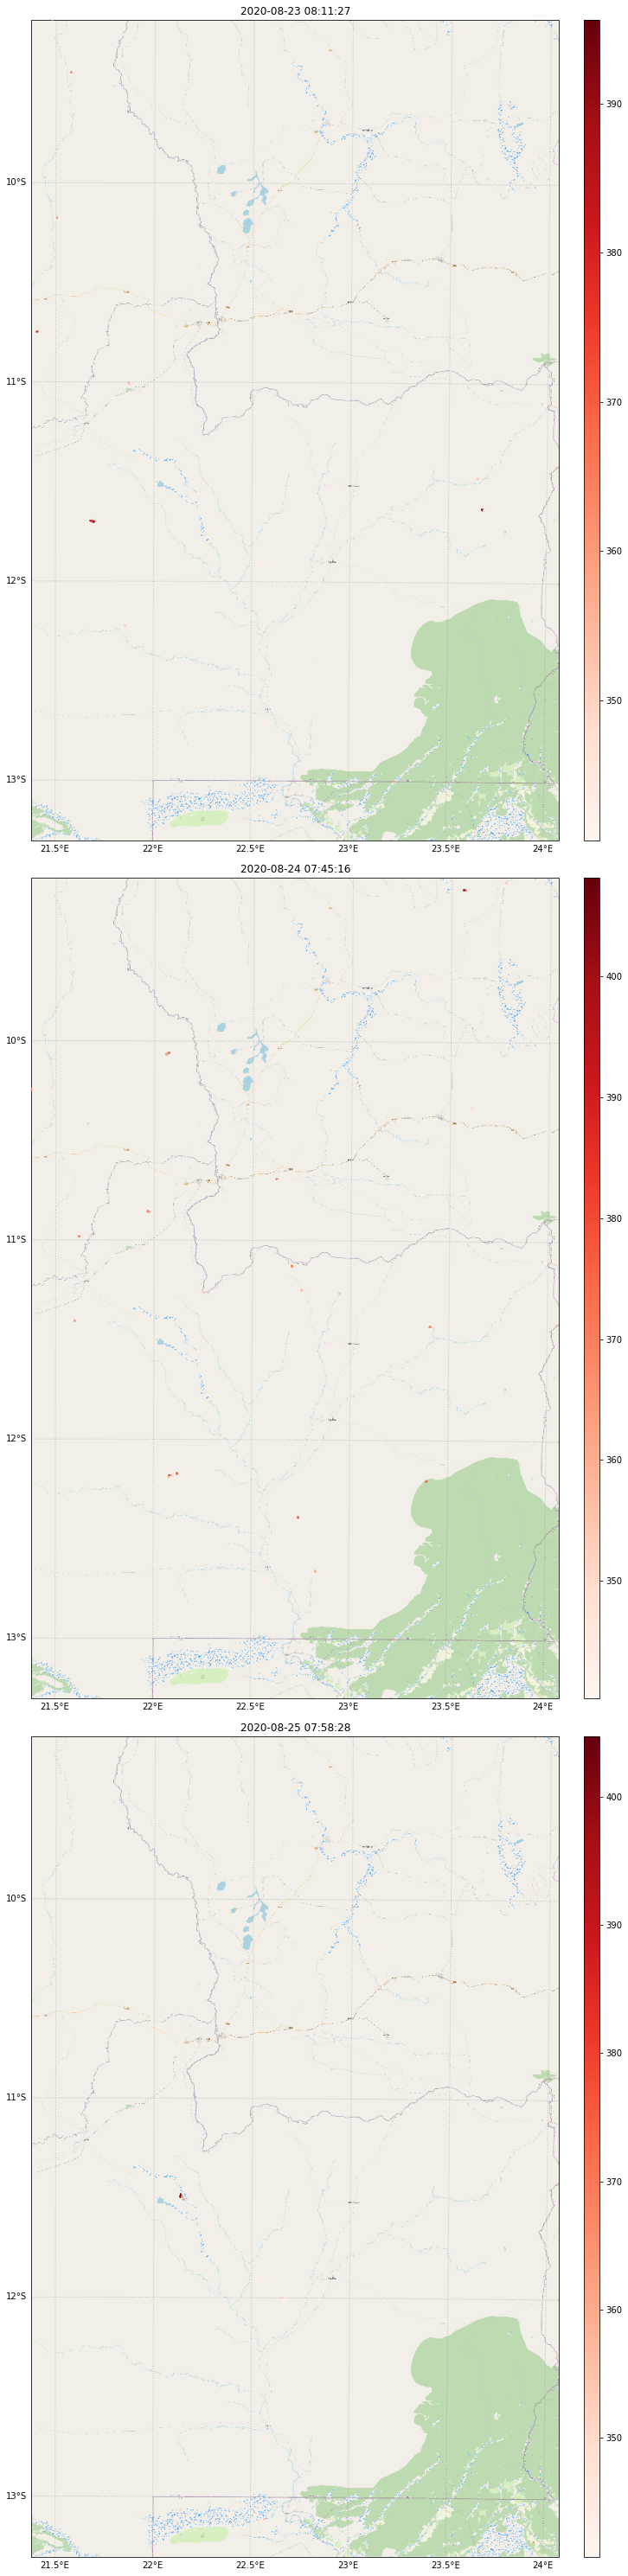

In [17]:
response.plotColorMesh( 'mask-temperature', osm_zoom=11, cmap='Reds' )